In [37]:
import pystan 
import numpy as np
import matplotlib.pyplot as plt
import arviz as av
import pickle
from scipy.stats import entropy
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Custom Function 

In [49]:
def PredictHardClass(model, D_pool):
    '''
    Using the model "model", predict hard classification for each data
    in the D_pool (each row of D_pool)
    Inputs:
        model: sklearn.linear_model e.g. sklearn.linear_model._logistic.LogisticRegression
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
    Outputs:
        T_hat: numpy.ndarray where each row is hard prediction of D_pool
    '''
    T_hat = model.predict(D_pool)
    return T_hat

def PredictSoftClass(model, D_pool):
    '''
    Using the model "model", predict hard classification for each data
    in the D_pool (each row of D_pool)
    Inputs:
        model: sklearn.linear_model e.g. sklearn.linear_model._logistic.LogisticRegression
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
    Outputs:
        T_proba: numpy.ndarray where each row is soft prediction of D_pool
    '''
    T_proba = model.predict_proba(D_pool)
    return T_proba

def getEntropy(T_proba):
    '''
    Using the model "model", predict hard classification for each data
    in the D_pool (each row of D_pool)
    Inputs:
        T_proba: numpy.ndarray where each row is soft prediction of D_pool
    Outputs:
        Ent: numpy.ndarray where each row is entropy of D_pool data
    '''
    N = T_proba.shape[0]
    Ent = np.zeros(N)
    for i in range(N):
        Ent[i] = entropy(T_proba[i], base = 2)
    return Ent

def Create_Fit_Save_Extract_StanModel(no_classes, D_Train, T_Train, filename):
    '''
    Using the model "model", predict hard classification for each data
    in the D_pool (each row of D_pool)
    Inputs:
        T_Train: numpy.ndarray (one hot vector) where each row is soft prediction of D_pool
    Outputs:
        Ent: numpy.ndarray where each row is entropy of D_pool data
    '''
    onehot_encoder = OneHotEncoder(sparse=False)
    T_Train = T_Train.reshape(len(T_Train), 1)
    T_Train = onehot_encoder.fit_transform(T_Train)
    T_Train = T_Train.astype(np.int)
    log_reg_data = {
             'N': D_Train.shape[0],
             'K': no_classes,
             'M': D_Train.shape[1],
             'X': D_Train,
             'Y': T_Train
            }
    
    sm = pystan.StanModel(file=filename)
    fit = sm.sampling(data=log_reg_data, iter=1000, chains=2)
    params = fit.extract()
    with open('model_fit.pkl','wb') as f:
        pickle.dump({'model':sm, 'fit':fit},f)
        
    with open('model_fit.pkl','rb') as f:
        data_dict = pickle.load(f)
        
    fit = data_dict['fit']
    sm = data_dict['model']
    return params, fit, sm

def Extract_4m_savedStanModel(filename):
    '''
    Using the model "model", predict hard classification for each data
    in the D_pool (each row of D_pool)
    Inputs:
        T_Train: numpy.ndarray (one hot vector) where each row is soft prediction of D_pool
    Outputs:
        Ent: numpy.ndarray where each row is entropy of D_pool data
    '''
    with open(filename,'rb') as f:
        data_dict = pickle.load(f)
        
    fit = data_dict['fit']
    sm = data_dict['model']
    params = fit.extract()
    return params, fit, sm

def Predict_proba_4m_thetasamples(beta_samples, D_pool):
    '''
    
    Inputs:
        : 
    Outputs:
        : 
    '''
    no_beta_samples = beta_samples.shape[0]
    no_features = beta_samples.shape[1]
    no_classes = beta_samples.shape[2]
    N = D_pool.shape[0]
    
    pred_prob = np.zeros((no_beta_samples, N, no_classes))
    for i in range(no_beta_samples):
        pred_prob[i] = D_pool @ beta_samples[i]
        for j in range(N):
            for k in range(no_classes):
                pred_prob[i,j,k] = np.exp(pred_prob[i,j,k])
            norm = np.sum(pred_prob[i,j,:], dtype = np.float32)
            pred_prob[i,j,:] = pred_prob[i,j,:]/norm
    return pred_prob

def Compute_Expec_Entropy(beta_samples, D_pool):
    '''
    
    Inputs:
        : 
    Outputs:
        : 
    '''
    pred_prob = Predict_proba_4m_thetasamples(beta_samples, D_pool)
    no_samples = pred_prob.shape[0]
    N = pred_prob.shape[1]
    
    Ent = np.zeros((no_samples,N))
    Expec_Ent = np.zeros(N)
    for i in range(no_samples):
        Ent[i,:] = getEntropy(pred_prob[i])
    Expec_Ent = np.mean(Ent, axis = 0)
    return Ent, Expec_Ent

def BALD_Acq_Fn(beta_samples, D_pool, model):
    '''
    
    Inputs:
        : 
    Outputs:
        : 
    '''
    T_proba = PredictSoftClass(model, D_pool)
    Ent1 = getEntropy(T_proba)
    Ent_Samp, Ent2 = Compute_Expec_Entropy(beta_samples, D_pool)
    BALD_AF = Ent1 - Ent2
    return BALD_AF

def Find_argmax_AF(n, AF_pool):
    '''
    
    Inputs:
        : 
    Outputs:
        : 
    '''
    arg_nmax = np.argpartition(AF_pool,-n)[-n:]
    return arg_nmax

def PicknDelete_4mPool(arg_nmax, D_pool, T_pool, AF):
    '''
    
    Inputs:
        :  
    Outputs:
        : 
    '''
    D_select = np.take(D_pool, arg_nmax, axis = 0)
    T_select = np.take(T_pool, arg_nmax, axis = 0)
    AF_select = np.take(AF, arg_nmax, axis = 0)
    
    
    D_pool_upd = np.delete(D_pool, arg_nmax, axis=0)
    T_pool_upd = np.delete(T_pool, arg_nmax, axis=0)
    AF_upd = np.delete(AF, arg_nmax, axis=0)
    return D_select, T_select, D_pool_upd, T_pool_upd

def Add_2Train(D_select, T_select, D_Train, T_Train):
    '''
    
    Inputs:
        : 
    Outputs:
        : 
    '''
    D_Train_upd = np.vstack((D_Train, D_select))
    T_Train_upd = np.concatenate([T_Train,T_select])
    return D_Train_upd, T_Train_upd



# Main Program

In [50]:
# Data Generation and Train, Test, AL Poolset creation
no_classes = 3
no_features = 5
no_samples = 1500
# Generate Data
X, y = make_classification(n_samples=no_samples, n_features=no_features, n_informative=3, n_redundant=2, n_classes=no_classes, random_state=1)

# Split Generated Data for initial Training and the Left over part
D_Train, D_left, T_Train, T_left = train_test_split(X, y, test_size=0.96, random_state=42)

# Split Left over Data for Testing and the Active Learning Poolset
D_test, D_pool, T_test, T_pool = train_test_split(D_left, T_left, test_size=0.75, random_state=40)



In [51]:
# Initial Training of data - Model => Logistic Regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(D_Train, T_Train)

LogisticRegression(multi_class='multinomial')

In [52]:
print(D_Train.shape)
print(D_test.shape)
print(D_pool.shape)
print(T_Train.shape)
print(T_test.shape)
print(T_pool.shape)

(60, 5)
(360, 5)
(1080, 5)
(60,)
(360,)
(1080,)


In [53]:
# Testing the initial LR model on TEST data
T_test_mod_proba = np.zeros((len(D_test),no_classes))
T_test_mod = np.zeros(len(D_test))
for i in range(len(D_test)):
    T_test_mod_proba = model.predict_proba(D_test)
    T_test_mod= model.predict(D_test)


acc = []
acc.append(accuracy_score(T_test, T_test_mod))
cm = []
cm.append(confusion_matrix(T_test, T_test_mod))

In [54]:
print(T_test_mod.shape)
print(T_test_mod_proba.shape)

(360,)
(360, 3)


In [55]:
AL_bound = 20
no_select = 1
select_count = []
i = 0
while i <= AL_bound:
    print(i)
    T_pool_predproba = PredictSoftClass(model, D_pool)
    #print(T_pool_predproba)
    AF_Ent = getEntropy(T_pool_predproba)
    print(AF_Ent.shape)
    arg_nmax = Find_argmax_AF(no_select, AF_Ent)
    print(arg_nmax)
    D_select, T_select, D_pool, T_pool = PicknDelete_4mPool(arg_nmax, D_pool, T_pool, AF_Ent)
    D_Train, T_Train = Add_2Train(D_select, T_select, D_Train, T_Train)
    model.fit(D_Train, T_Train)
        
    T_test_mod_proba = PredictSoftClass(model, D_test)
    T_test_mod= PredictHardClass(model, D_test)
        
    acc.append(accuracy_score(T_test, T_test_mod))
    cm.append(confusion_matrix(T_test, T_test_mod))
    
    
    i = i+no_select
    select_count.append(i)
    

0
(1080,)
[140]
1
(1079,)
[221]
2
(1078,)
[1003]
3
(1077,)
[455]
4
(1076,)
[184]
5
(1075,)
[673]
6
(1074,)
[1040]
7
(1073,)
[235]
8
(1072,)
[1016]
9
(1071,)
[420]
10
(1070,)
[728]
11
(1069,)
[180]
12
(1068,)
[332]
13
(1067,)
[392]
14
(1066,)
[107]
15
(1065,)
[819]
16
(1064,)
[831]
17
(1063,)
[326]
18
(1062,)
[602]
19
(1061,)
[308]
20
(1060,)
[728]


In [56]:
acc

[0.7555555555555555,
 0.7611111111111111,
 0.7472222222222222,
 0.7555555555555555,
 0.7583333333333333,
 0.7555555555555555,
 0.7694444444444445,
 0.775,
 0.775,
 0.775,
 0.7805555555555556,
 0.7805555555555556,
 0.7861111111111111,
 0.7777777777777778,
 0.7777777777777778,
 0.7777777777777778,
 0.7888888888888889,
 0.7916666666666666,
 0.7888888888888889,
 0.7861111111111111,
 0.7888888888888889,
 0.7833333333333333]

Text(0, 0.5, 'Accuracy')

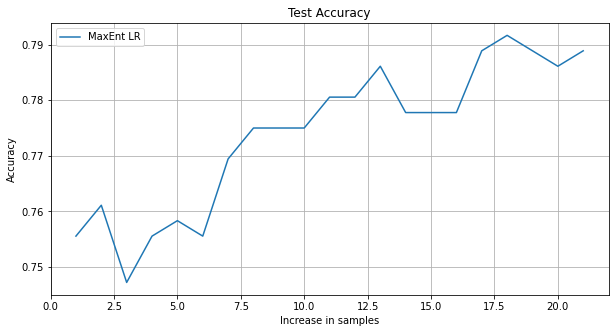

In [57]:
fig = plt.figure(figsize=(10,5))
plt.grid(True, which ="both")
plt.plot(select_count, acc[0:-1])
plt.legend(['MaxEnt LR'])
plt.title('Test Accuracy')
plt.xlabel('Increase in samples')
plt.ylabel('Accuracy')